# HA 1
prepared by Danila Danko

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Task 1. Case 1

[]

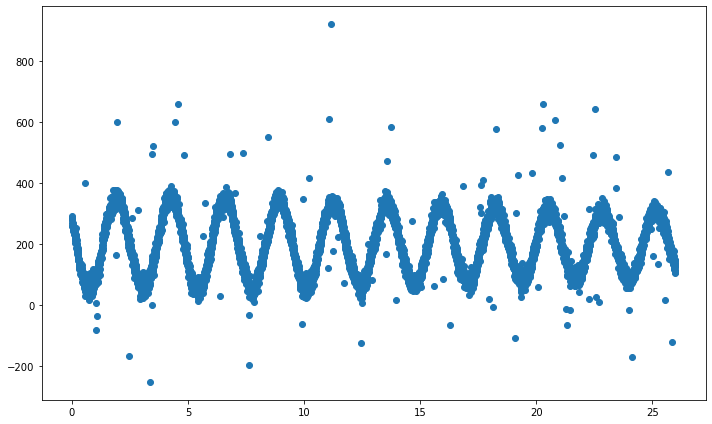

In [2]:
N = 1
df = pd.read_csv(f'./Task01/case{N}.txt', header=None,names=['x','y'])
fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(10, 6))
axs.scatter(df.x,df.y)
plt.tight_layout()
plt.plot()

This seems to be a $sin$ wave

In [3]:
x = df.x.to_numpy()
y = df.y.to_numpy()

I want to fit the curve $y(x) = A \ sin (B \ x + C) + D$.

For this, I will use Gauss-Newton's method suggested [here](https://math.stackexchange.com/a/319118).

In [4]:
import sympy as sp
A,B,C,D,X,Y = sp.symbols('A B C D X Y')
f = A * sp.sin(B * X + C) + D
F = sp.Matrix([f])
F = F.jacobian([A,B,C,D])
F

Matrix([[sin(B*X + C), A*X*cos(B*X + C), A*cos(B*X + C), 1]])

In [5]:
from sympy.utilities.lambdify import lambdify
Jl = lambdify([A,B,C,D,X],F)
Rl = lambdify([A,B,C,D,X,Y],Y-f)

My initial guesses are: $A = 400, B = 2.5, C = \frac{\pi}{2}, D=200$. 

They're made by observing the plot.

In [6]:
def fit(x,y,iterations=100):
    N = iterations
    T = len([A,B,C,D])
    M = len(x)
    beta = np.array([500,2.5,np.pi/2,200])
    alpha = 0.0001
    for _ in range(N):
        J = np.zeros((M,T))
        R = np.zeros((M,1))
        a,b,c,d = [i for i in beta]
        alpha = 0.1
        for j in range(M):
            J[j] = Jl(*[a,b,c,d,x[j]])
            R[j] = Rl(*[a,b,c,d,x[j],y[j]])
        db = np.linalg.inv(J.T.dot(J)).dot(J.T).dot(R)
        beta = beta + alpha * db.ravel()
    return beta

bt = fit(x=x,y=y)
print(bt)

[ 27.9214062    2.35195836   4.18817253 197.78246734]


[]

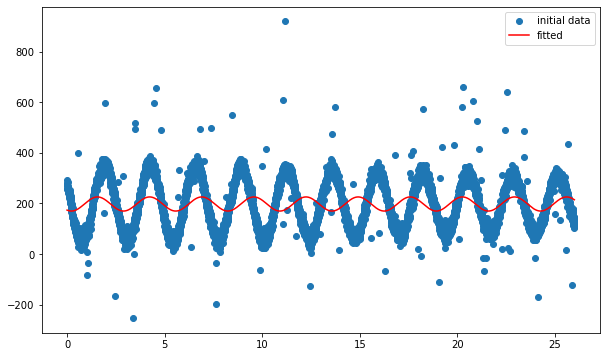

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.scatter(x,y,label='initial data')
A_, B_, C_, D_ = bt
ans = A_ * np.sin(x * B_ + C_) + D_
ax.plot(x, ans,c='r',label='fitted')
ax.legend()
plt.plot()

It's said that the method [may not converge](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm#Convergence_properties).

Probably, that's my case. 

## Task 2. Id=8

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
N = 5
df = pd.read_csv(f'./Task02/data_set_8_.txt', header=None, names=['x','y','z'])
fig = plt.figure()
x = df.x.to_numpy()
y = df.y.to_numpy()
z = df.z.to_numpy()

<Figure size 432x288 with 0 Axes>

This seems to be a plane. Let's add some outliers

In [10]:
x[:5] += 3

Now, I set `min_samples = 3`, since it's the minimal number of points required to construct a plane from a non-degenerate triangle.

Next, I set the `residual_threshold` to `median absolute deviation` (formula is given [here](https://en.wikipedia.org/wiki/Median_absolute_deviation)). This is a "robust estimator of dispersion", that's why I use it.

After `100` iterations, I saw the outliers are marked blue, so `100` is enough for RANSAC to exclude them.

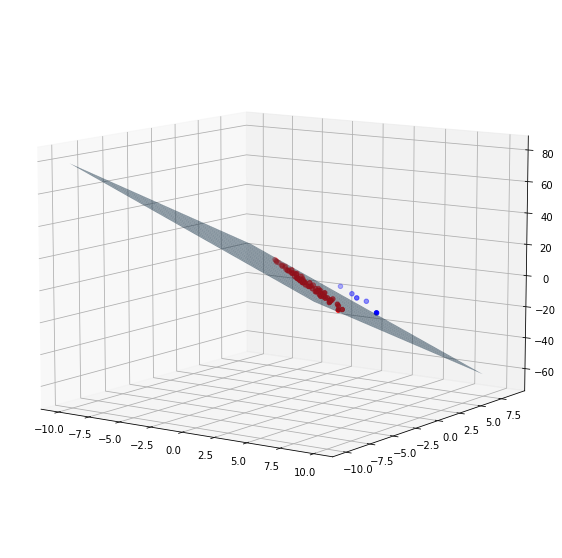

In [21]:
# %matplotlib qt
from sklearn import linear_model

X = np.array([x,y]).T
Y = z
T = np.median(np.abs(z - np.median(z)))

ransac = linear_model.RANSACRegressor(min_samples=3, residual_threshold=T, max_trials=100)
ransac.fit(X, Y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

xa = X[inlier_mask].T[0]
ya = X[inlier_mask].T[1]
za = Y[inlier_mask]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=10, azim=-55, )

ax.scatter(xa, ya, za, c='r')

xna = X[outlier_mask].T[0]
yna = X[outlier_mask].T[1]
zna = Y[outlier_mask]

ax.scatter(xna, yna, zna, c='b')

xc, yc = ransac.estimator_.coef_
zc = ransac.estimator_.intercept_

xx, yy = np.meshgrid(range(-10,10), range(-10,10))
zz = xc * xx + yc * yy + zc
ax.plot_surface(xx, yy, zz, alpha=0.5)